<a href="https://colab.research.google.com/github/BrunoEMendes/Google_colab_NN/blob/master/GRU_ML_RESULTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Wind Turbines Vibrations with GRU

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import keras


## Data Manipulation

### Loading Data

In [ ]:
import scipy.io
from scipy import stats

filepath = 'C00L1S30R01_Ch003.mat'
data = scipy.io.loadmat(filepath)['Data_Ch_003']
stats.describe(data)

DescribeResult(nobs=2004300, minmax=(array([-20.58761], dtype=float32), array([20.677141], dtype=float32)), mean=array([3.4142957], dtype=float32), variance=array([8.919818], dtype=float32), skewness=array([0.05763561], dtype=float32), kurtosis=array([0.7683346], dtype=float32))

We have 2004300 values as input, which means the values were registered over a course of 20 sec

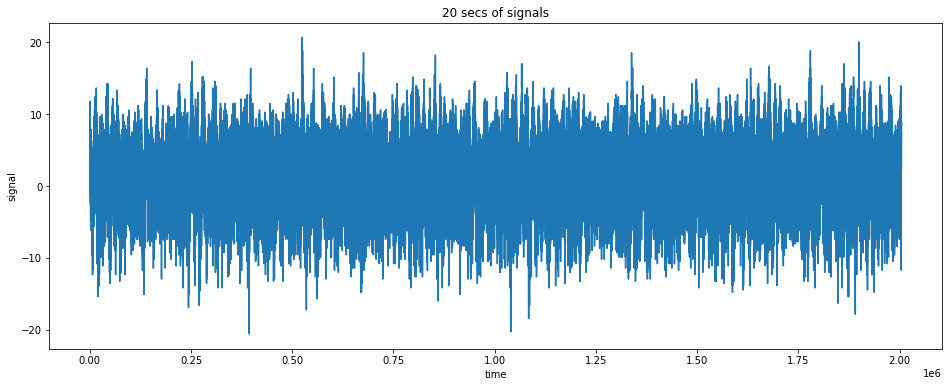

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize =(16, 6))
plt.plot(data)
plt.xlabel('time')
plt.ylabel('signal')
plt.title('20 secs of signals')
plt.show()

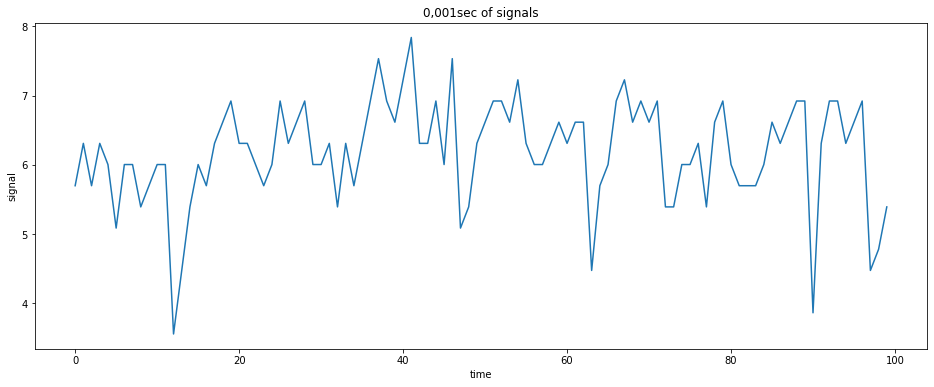

In [ ]:
plt.figure(1, figsize =(16, 6))
plt.plot(data[:100])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('0,001sec of signals')
plt.show()

### Data Normalization

To avoid exploding gradients, we have to normalize the data between 0 and 1.
In this case is I choose 0 and 1 because the GRU gates use sigmoid as activation function.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range = (0, 1))

def normalize_data(data):
  return min_max_scaler.fit_transform(data)

We will also need a function to reverse this values to compare with the real values later

In [ ]:
def inverse_normalization(y_inverted):
  return min_max_scaler.inverse_transform(y_inverted)

In [ ]:
norm_data = normalize_data(data)
print('  Normalized', 'Real data')
example = np.concatenate([norm_data[:12], inverse_normalization(norm_data[:12])], axis=1)
print(example)

  Normalized Real data
[[0.63703704 5.6995645 ]
 [0.65185183 6.3108935 ]
 [0.63703704 5.6995645 ]
 [0.65185183 6.3108935 ]
 [0.64444447 6.0052304 ]
 [0.62222224 5.088236  ]
 [0.64444447 6.0052304 ]
 [0.64444447 6.0052304 ]
 [0.6296296  5.393899  ]
 [0.63703704 5.6995645 ]
 [0.64444447 6.0052304 ]
 [0.64444447 6.0052304 ]]


### Train/Test Data Split

So now we need to build our train/test sets.

In [ ]:
# we define the ammount of the data that will be used as a test set
test_size = 0.2

# we will also define what ammount of data we want to use, because GRUS are quite expensive computationally
# in this case we will be using 200ms, that is, 20000 values

ammount_of_data = 20000

norm_data_cropped = norm_data[:ammount_of_data]
print('Test %:', test_size * 100)
print('Total Data used: ', ammount_of_data)
print('Percentage of Data used: ', ammount_of_data / data.shape[0] * 100)

Test %: 20.0
Total Data used:  20000
Percentage of Data used:  0.9978546125829466


Our target values will be the ones in the normalized data, therefore, $y = normalized\ data$

In [ ]:
from sklearn.model_selection import train_test_split


y = norm_data_cropped.ravel()

train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


### Build Time Series

We have obtained our train data but its still not good enough to use because GRU's use time series as inputs and what we have is just a 2d matrix, therefore we need to convert the train split data to time series

In [ ]:
# how many steps we want to look into the past
time_steps = 100

def get_data_time_steps(X, y, time_steps = 3):

    Xres = []
    yres = []

    for i in range(time_steps, len(X)):
        Xres.append(X[i - time_steps: i, : X.shape[1]])
        yres.append(y[i])

    return np.array(Xres), np.array(yres)

X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


## Gated Reccurent Unit

Although I'm gonna write this section, I actually used my computer to obtain the results instead of colab

### Model

This is a single layer gru, I made multiple tests with multilayer GRUs and Dropout layers in between to avoid overfitting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Input
from tensorflow.keras.optimizers import Adam


model = Sequential([
          Input(shape= (X_train.shape[1], X_train.shape[2])),
          GRU(256),
          Dense(1, activation = 'linear')
    ])

optimizer = Adam(learning_rate= 0.001)

model.compile(loss='mse', optimizer=optimizer)

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 256)               198912    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 199,169
Trainable params: 199,169
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 10
batch_size = 16
#I wont be using this model to train because I already got the results 
#model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

### Loading Existing Models

In [ ]:
!unzip L1N32T10

Archive:  L1N32T10.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


#### L1_N16_T10

In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 5k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 10
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15990, 10, 1)
y train shape:  (15990,)
X test shape:  (3990, 10, 1)
y test shape:  (3990,)


In [ ]:
loaded.evaluate(X_train, y_train)

500/500 [==============================] - 1s 2ms/step - loss: 6.3570e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0179 - cosine_proximity: 1.0000


[0.0006357032689265907, 0.0, 0.01791001670062542, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

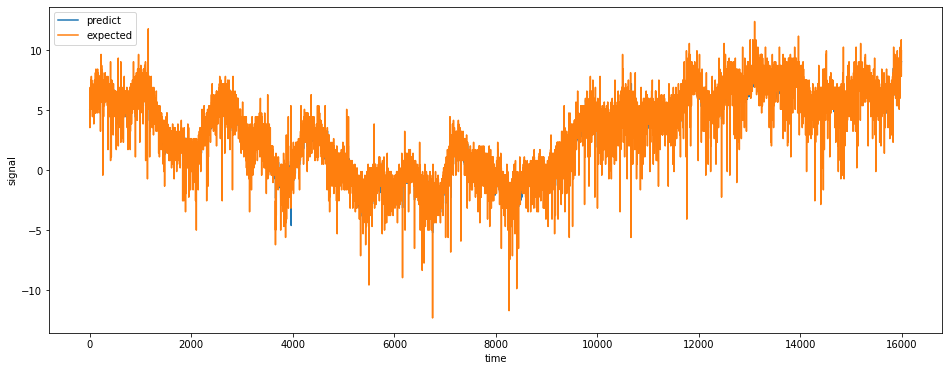

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

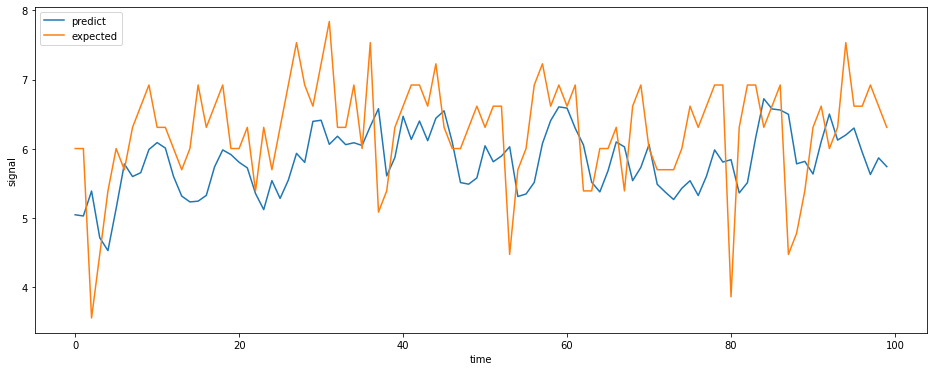

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.097269736


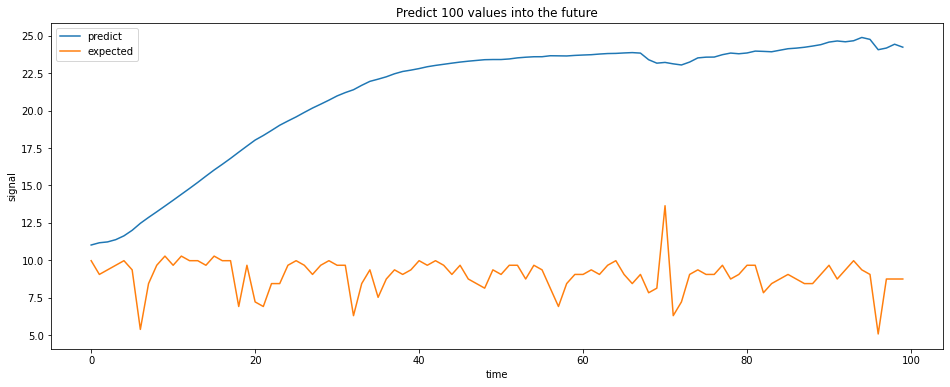

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N16_T50

In [ ]:
!unzip L1N16T50.zip

Archive:  L1N16T50.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 50
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15950, 50, 1)
y train shape:  (15950,)
X test shape:  (3950, 50, 1)
y test shape:  (3950,)


In [ ]:
loaded.evaluate(X_train, y_train)

499/499 [==============================] - 2s 4ms/step - loss: 5.2432e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0142 - cosine_proximity: 1.0000


[0.0005243204650469124, 0.0, 0.014240937307476997, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

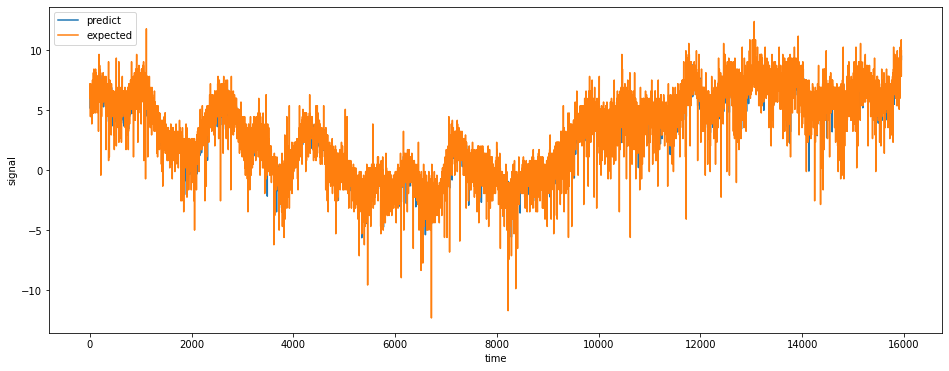

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

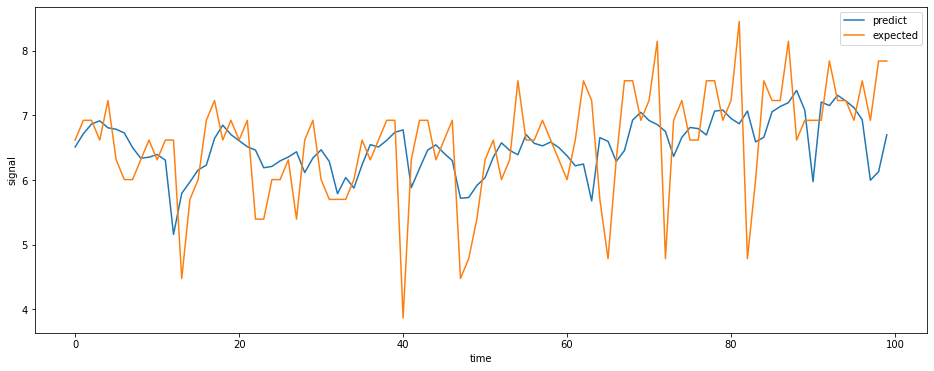

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0029324382


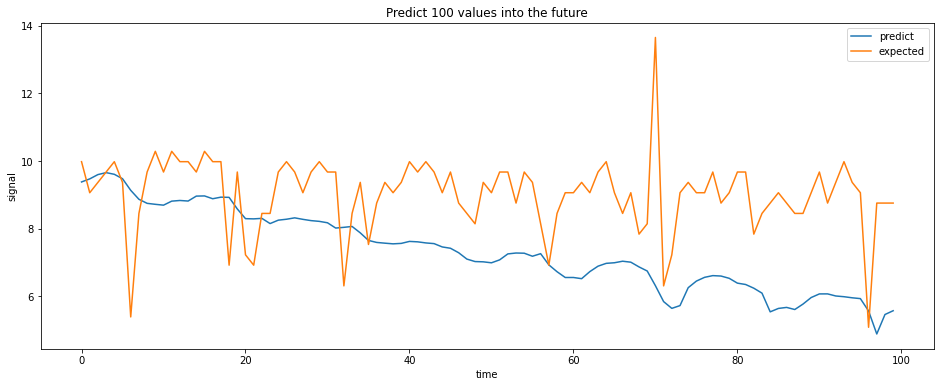

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N16_T100


In [ ]:
!unzip L1N16T100.zip

Archive:  L1N16T100.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 100

X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


In [ ]:
loaded.evaluate(X_train, y_train)

497/497 [==============================] - 4s 7ms/step - loss: 5.0955e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0144 - cosine_proximity: 1.0000


[0.0005095453816466033, 0.0, 0.01439456082880497, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

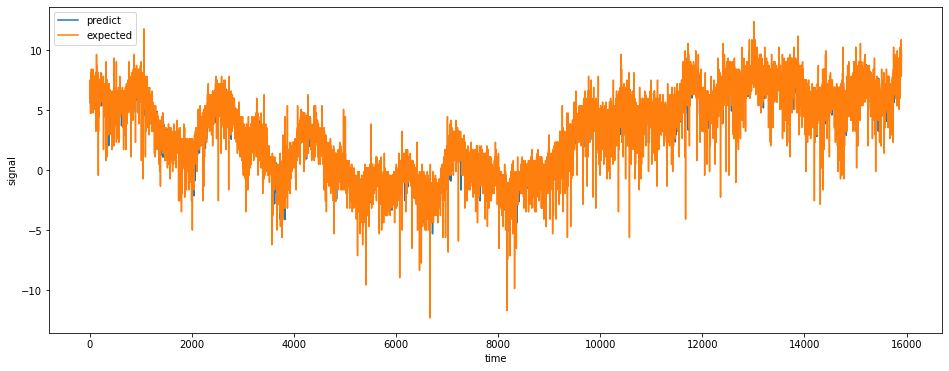

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

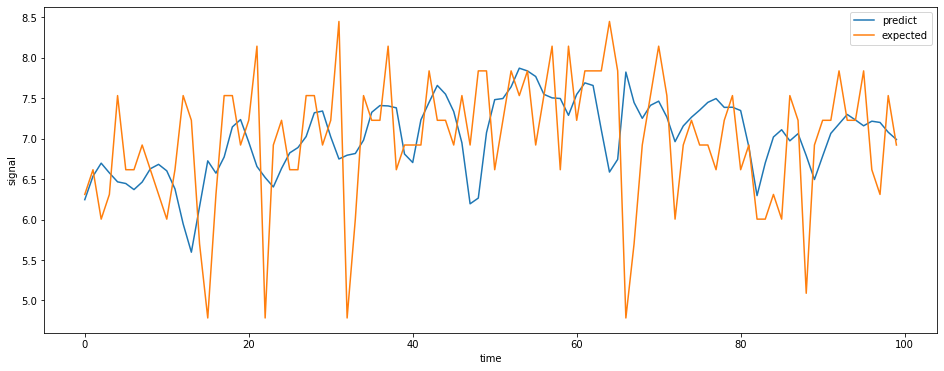

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0018039844


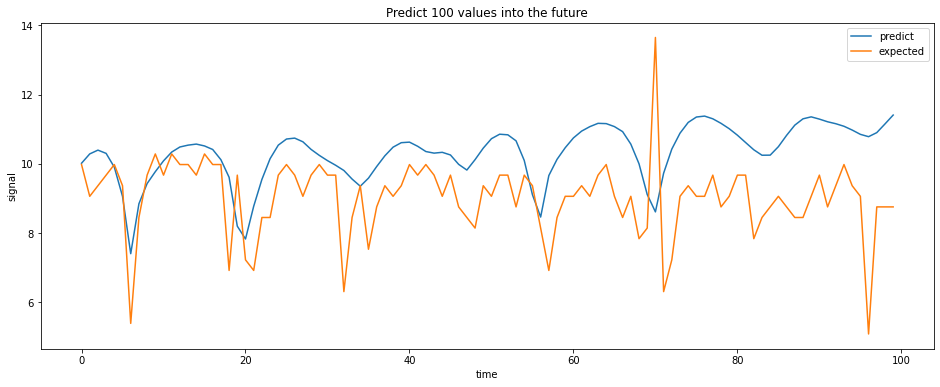

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N32_T10


In [ ]:
!unzip L1N32T10.zip

Archive:  L1N32T10.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 10
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15990, 10, 1)
y train shape:  (15990,)
X test shape:  (3990, 10, 1)
y test shape:  (3990,)


In [ ]:
loaded.evaluate(X_train, y_train)

500/500 [==============================] - 2s 2ms/step - loss: 6.3570e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0179 - cosine_proximity: 1.0000


[0.0006357032689265907, 0.0, 0.01791001670062542, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

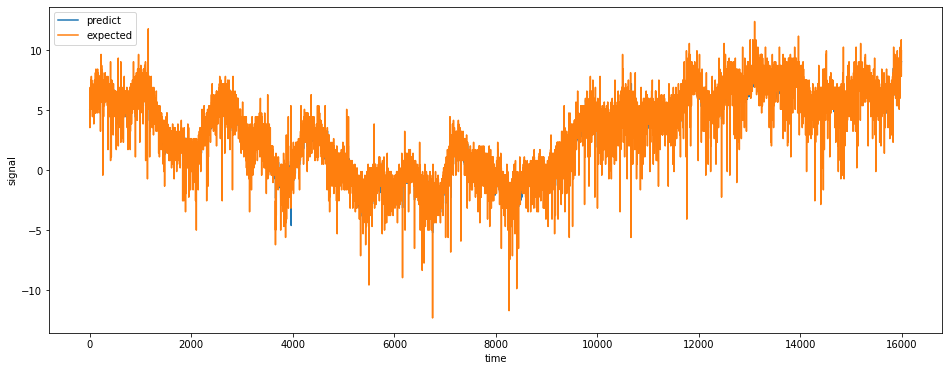

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

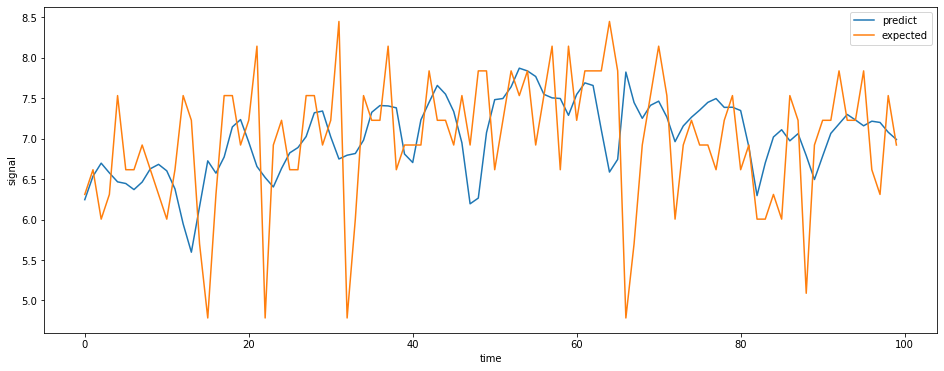

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0018039844


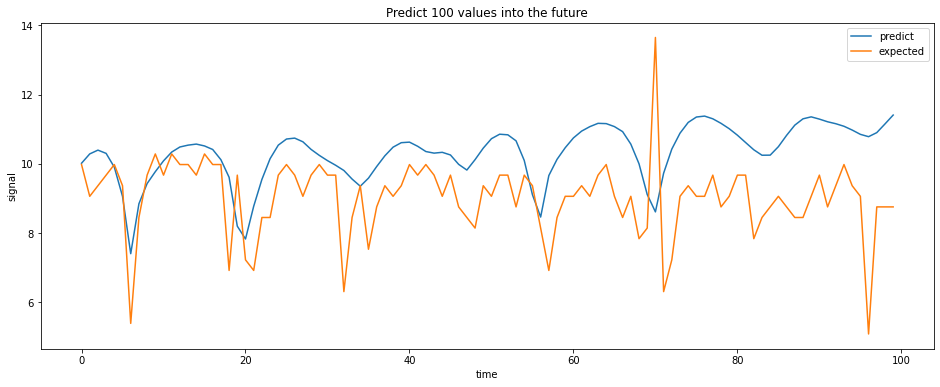

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N32_T50


In [ ]:
!unzip L1N32T50.zip

Archive:  L1N32T50.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 50
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15950, 50, 1)
y train shape:  (15950,)
X test shape:  (3950, 50, 1)
y test shape:  (3950,)


In [ ]:
loaded.evaluate(X_train, y_train)

499/499 [==============================] - 3s 5ms/step - loss: 5.1578e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0143 - cosine_proximity: 1.0000


[0.0005157835548743606, 0.0, 0.014315768145024776, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

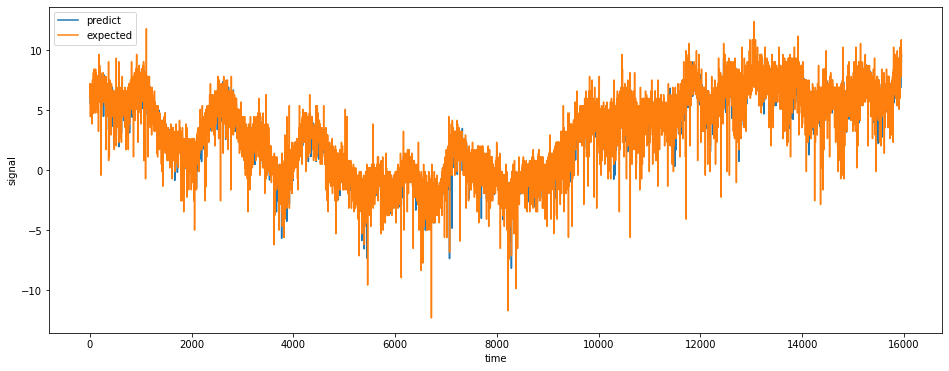

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

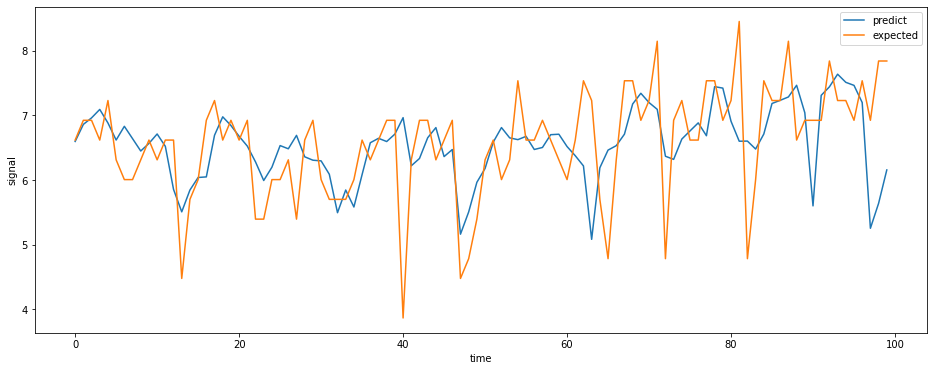

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0011470335


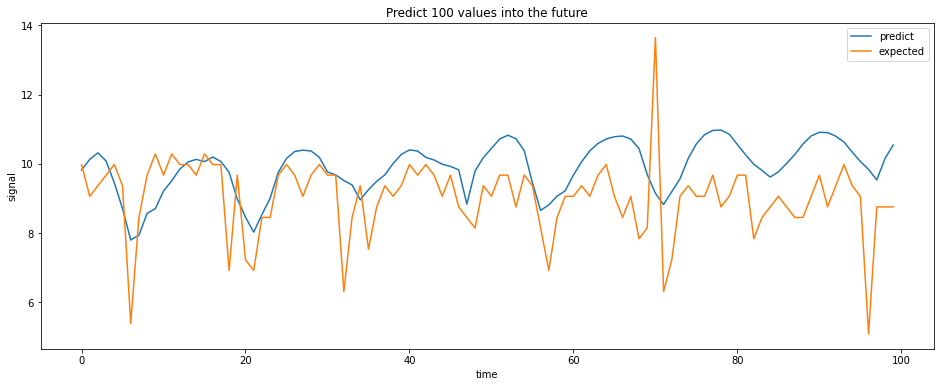

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N32_T100


In [ ]:
!unzip L1N32T100.zip

Archive:  L1N32T100.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 100
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


In [ ]:
loaded.evaluate(X_train, y_train)

497/497 [==============================] - 4s 8ms/step - loss: 4.7621e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0140 - cosine_proximity: 1.0000


[0.0004762112512253225, 0.0, 0.014041834510862827, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

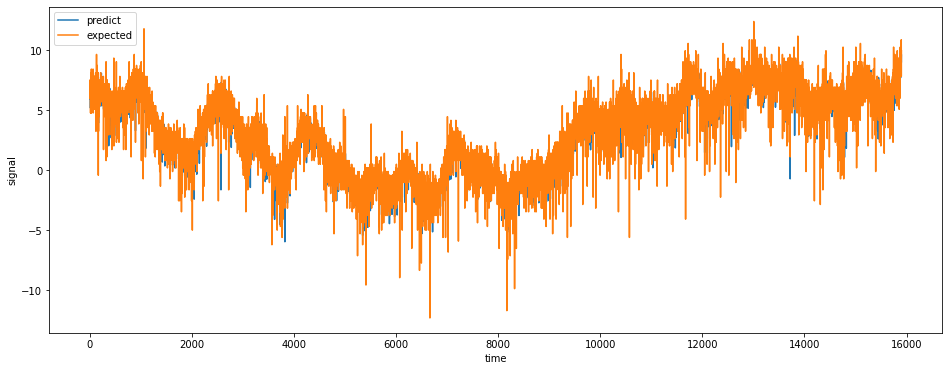

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

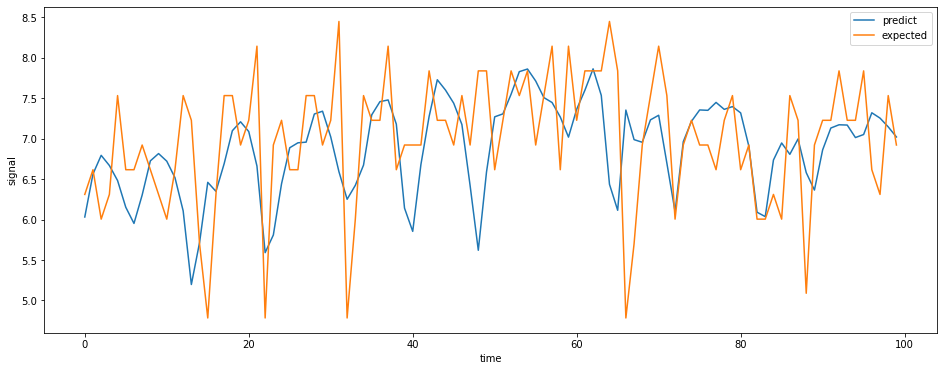

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.000673042


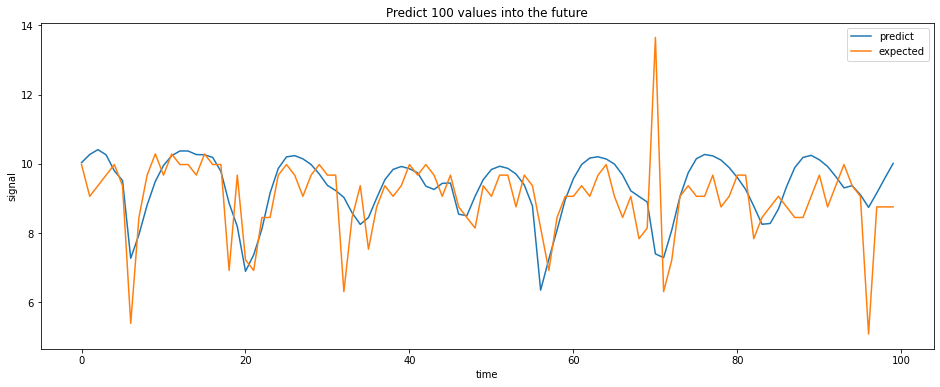

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N64_T10



In [ ]:
!unzip L1N64T10.zip

Archive:  L1N64T10.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 10
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15990, 10, 1)
y train shape:  (15990,)
X test shape:  (3990, 10, 1)
y test shape:  (3990,)


In [ ]:
loaded.evaluate(X_train, y_train)

500/500 [==============================] - 1s 2ms/step - loss: 7.9005e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0203 - cosine_proximity: 1.0000


[0.0007900461205281317, 0.0, 0.020287977531552315, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

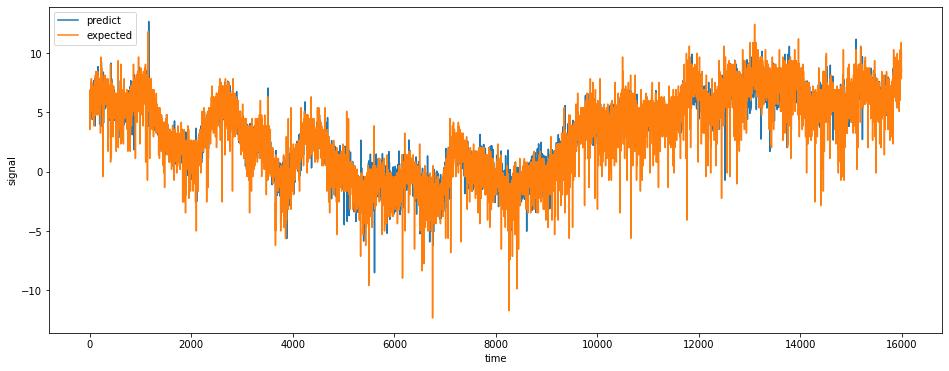

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

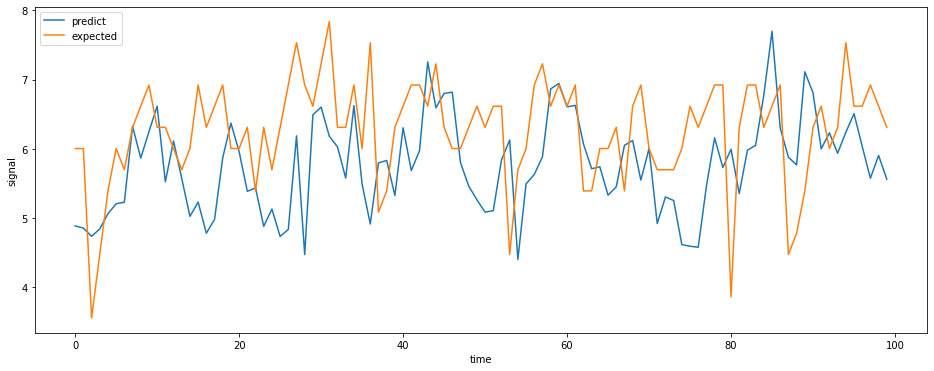

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.019404622


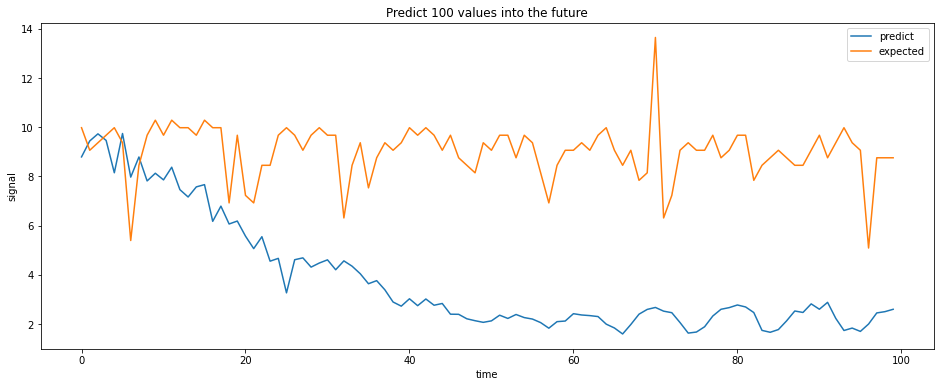

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N64_T50


In [ ]:
!unzip L1N64T50.zip

Archive:  L1N64T50.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 50
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15950, 50, 1)
y train shape:  (15950,)
X test shape:  (3950, 50, 1)
y test shape:  (3950,)


In [ ]:
loaded.evaluate(X_train, y_train)

499/499 [==============================] - 4s 7ms/step - loss: 6.9638e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0168 - cosine_proximity: 1.0000


[0.0006963753257878125, 0.0, 0.016772031784057617, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

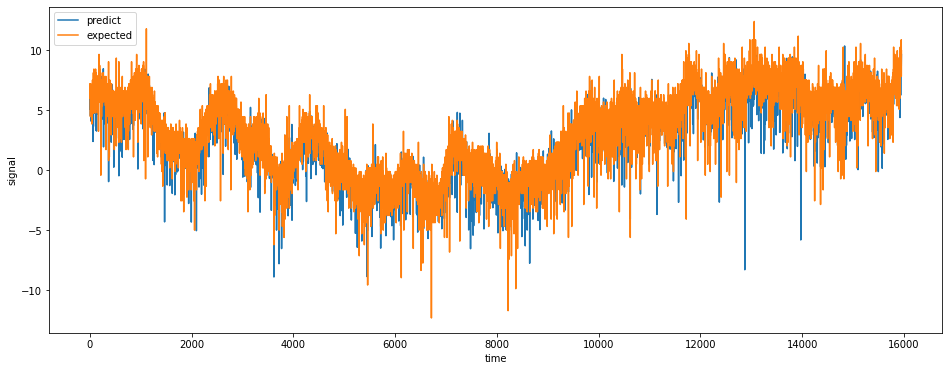

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

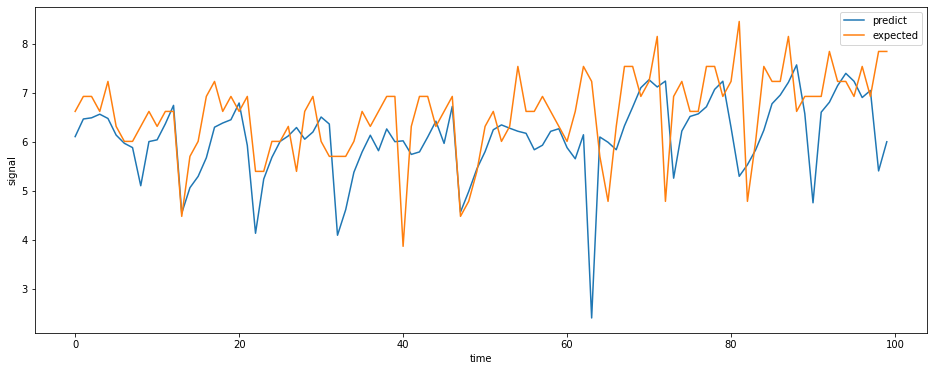

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0016612028


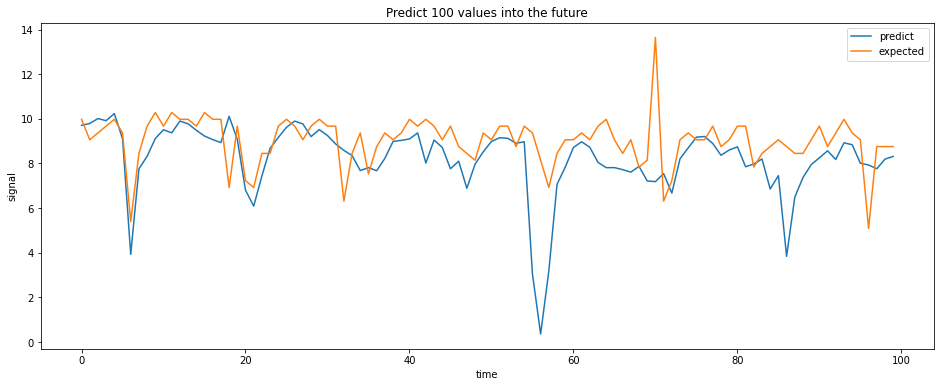

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N64_T100


In [ ]:
!unzip L1N64T100.zip

Archive:  L1N64T100.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 100
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


In [ ]:
loaded.evaluate(X_train, y_train)

497/497 [==============================] - 6s 11ms/step - loss: 5.6563e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0160 - cosine_proximity: 1.0000


[0.0005656330031342804, 0.0, 0.01604931801557541, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

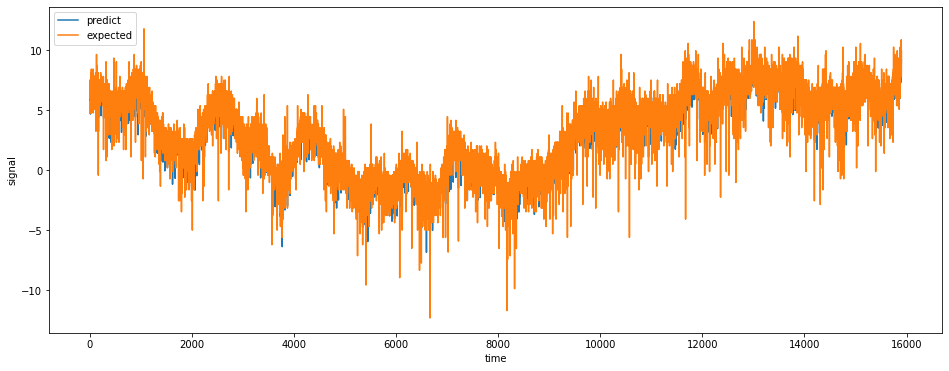

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

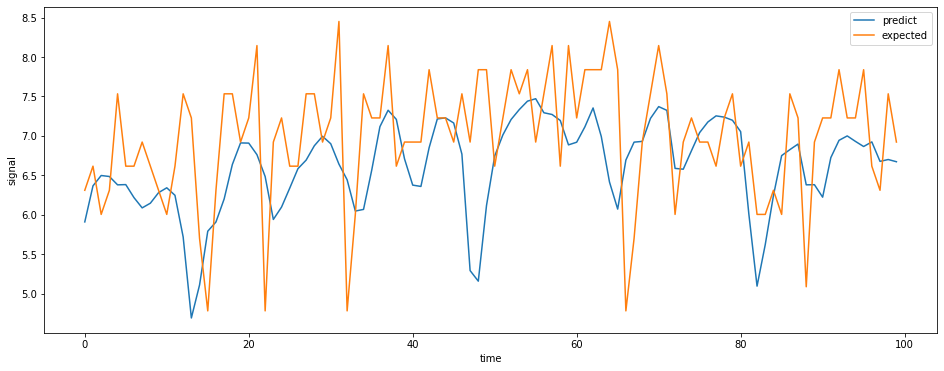

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0027832598


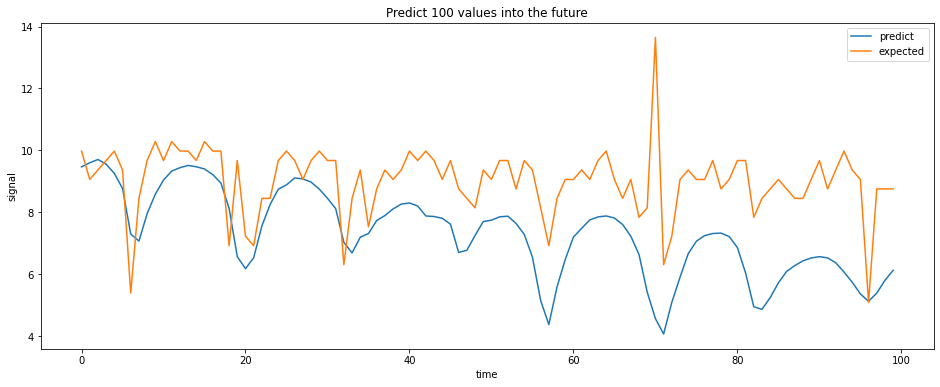

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N128_T10



In [ ]:
!unzip L1N128T10.zip

Archive:  L1N128T10.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 10
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15990, 10, 1)
y train shape:  (15990,)
X test shape:  (3990, 10, 1)
y test shape:  (3990,)


In [ ]:
loaded.evaluate(X_train, y_train)

500/500 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0298 - cosine_proximity: 1.0000


[0.0016337695997208357, 0.0, 0.029807887971401215, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

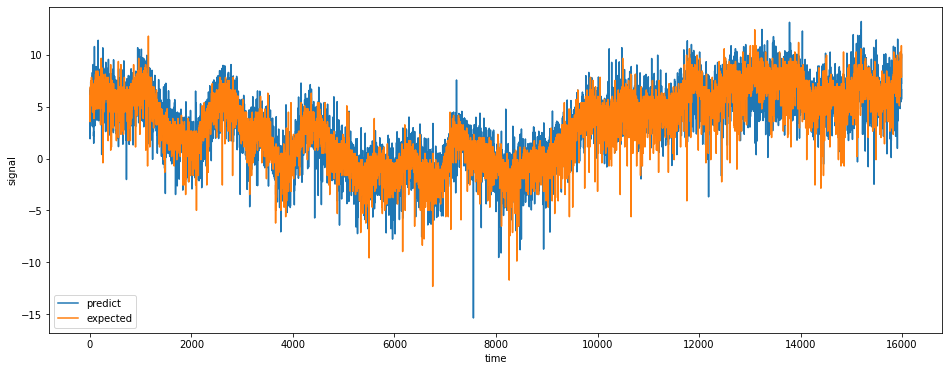

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

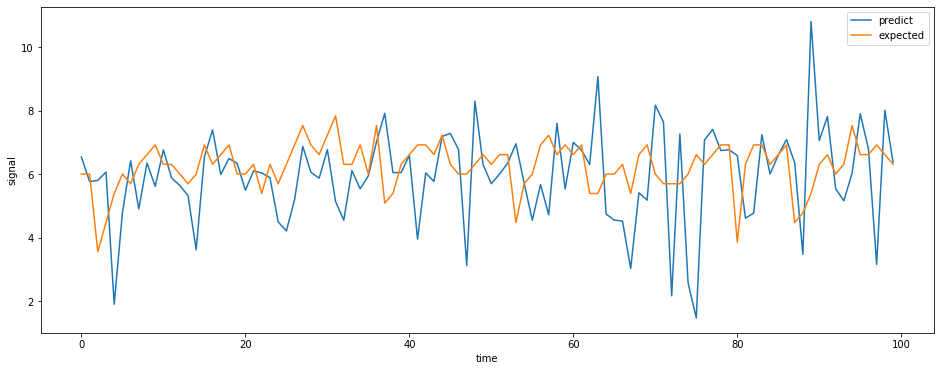

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0071976203


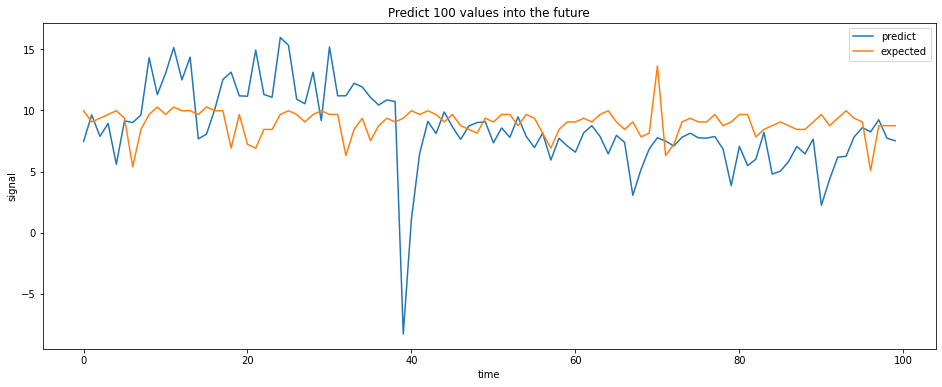

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N128_T50



In [ ]:
!unzip L1N128T50.zip

Archive:  L1N128T50.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 50
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15950, 50, 1)
y train shape:  (15950,)
X test shape:  (3950, 50, 1)
y test shape:  (3950,)


In [ ]:
loaded.evaluate(X_train, y_train)

499/499 [==============================] - 6s 12ms/step - loss: 9.4910e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0210 - cosine_proximity: 1.0000


[0.0009490952361375093, 0.0, 0.020958537235856056, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

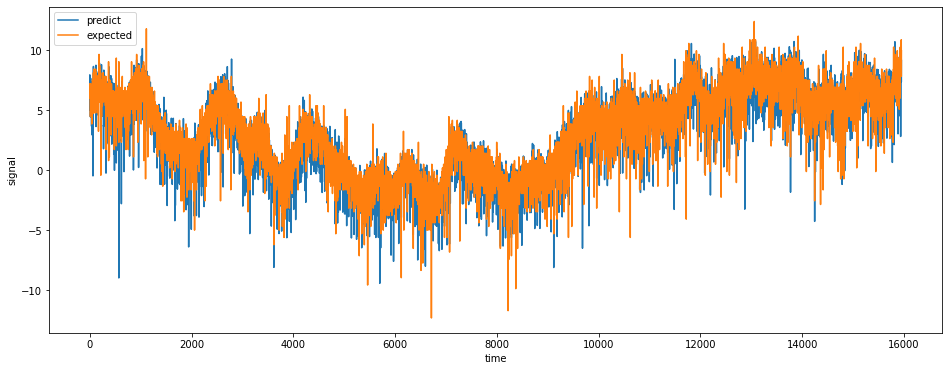

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

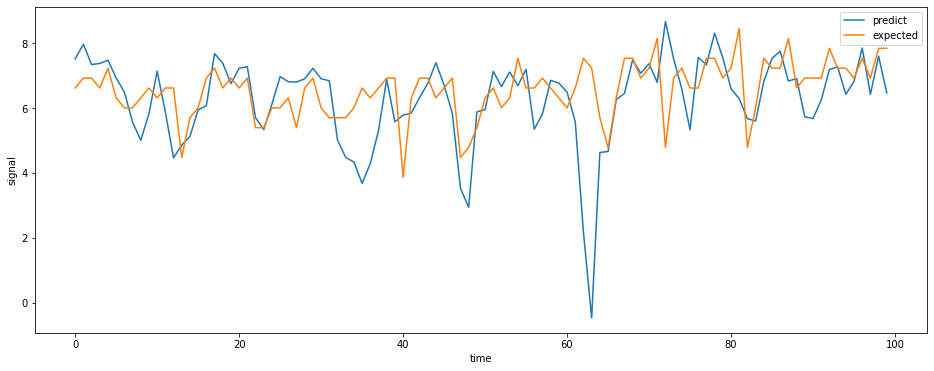

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0030567157


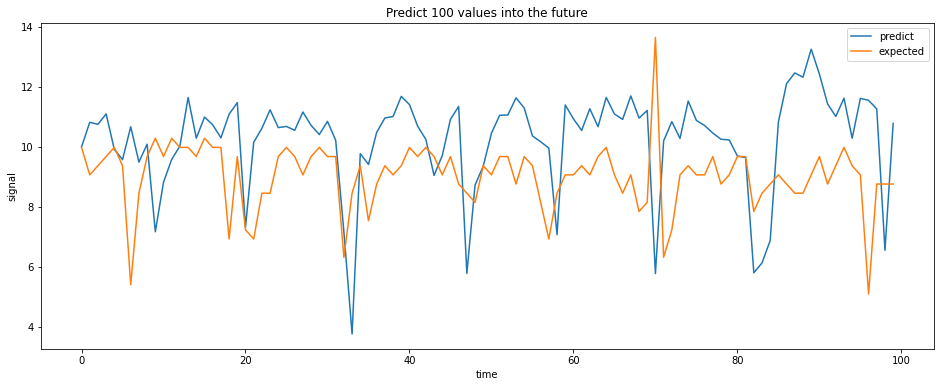

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N128_T100



In [ ]:
!unzip L1N128T100.zip

Archive:  L1N128T100.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 100
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


In [ ]:
loaded.evaluate(X_train, y_train)

497/497 [==============================] - 11s 22ms/step - loss: 5.7137e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0165 - cosine_proximity: 1.0000


[0.00057137047406286, 0.0, 0.016478145495057106, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

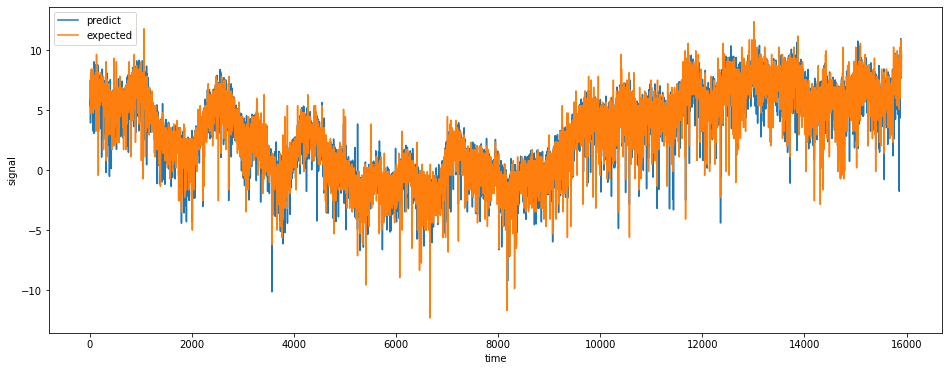

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

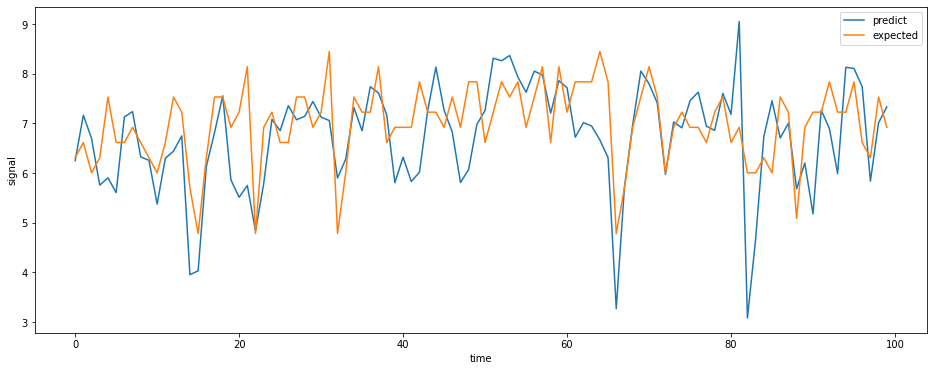

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0014426291


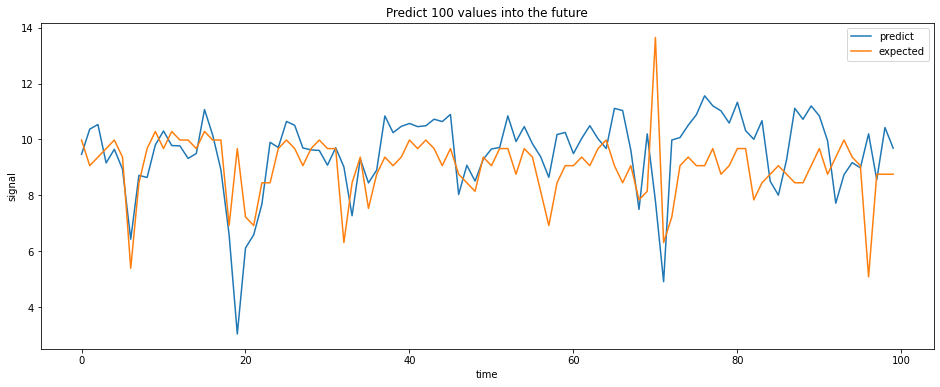

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N256_T50



In [ ]:
!unzip L1N256T50.zip

Archive:  L1N256T50.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 50
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15950, 50, 1)
y train shape:  (15950,)
X test shape:  (3950, 50, 1)
y test shape:  (3950,)


In [ ]:
loaded.evaluate(X_train, y_train)

499/499 [==============================] - 18s 36ms/step - loss: 6.1625e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0168 - cosine_proximity: 1.0000


[0.0006162452627904713, 0.0, 0.01678890362381935, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

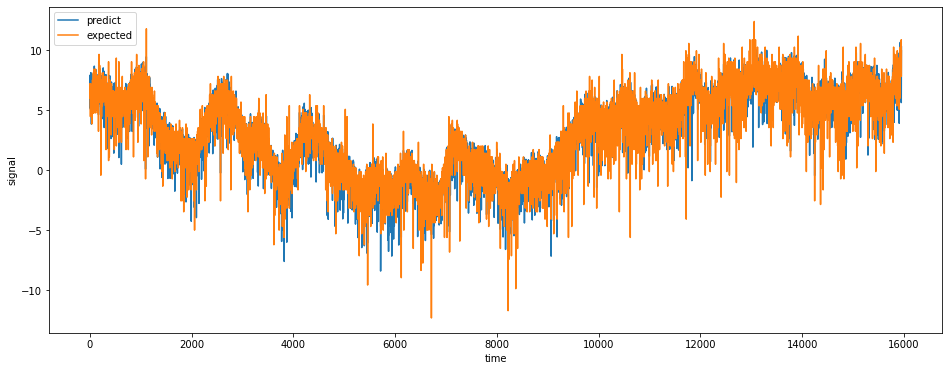

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

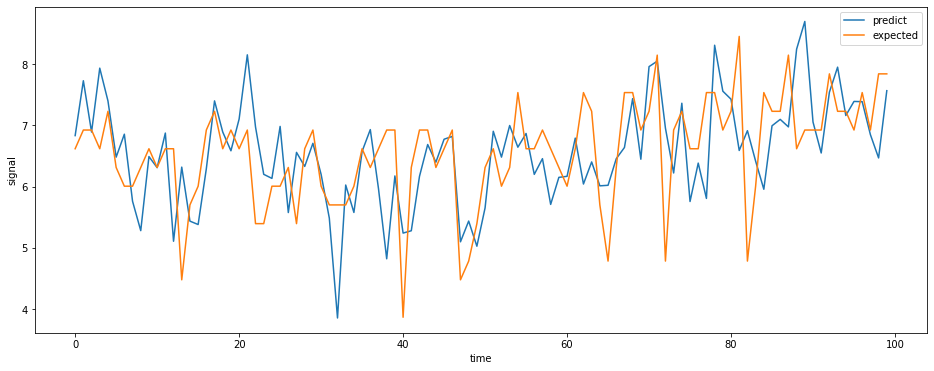

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0007607549


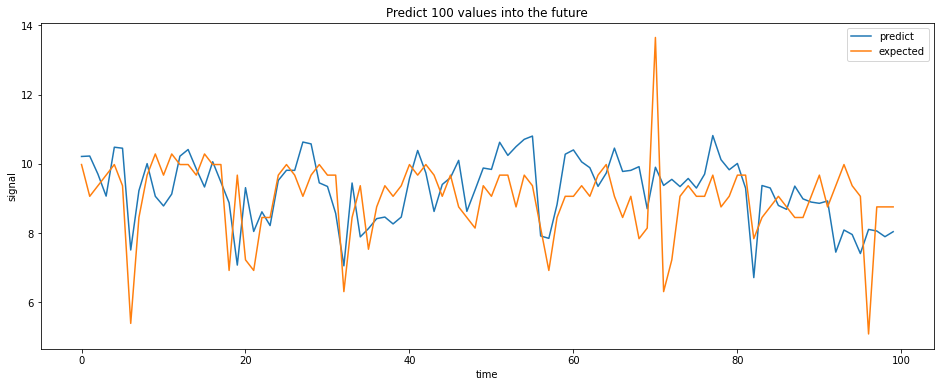

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N256_T10



In [ ]:
!unzip L1N256T10.zip

Archive:  L1N256T10.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 10
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15990, 10, 1)
y train shape:  (15990,)
X test shape:  (3990, 10, 1)
y test shape:  (3990,)


In [ ]:
loaded.evaluate(X_train, y_train)

500/500 [==============================] - 5s 9ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0251 - cosine_proximity: 1.0000


[0.0012014306848868728, 0.0, 0.025121791288256645, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

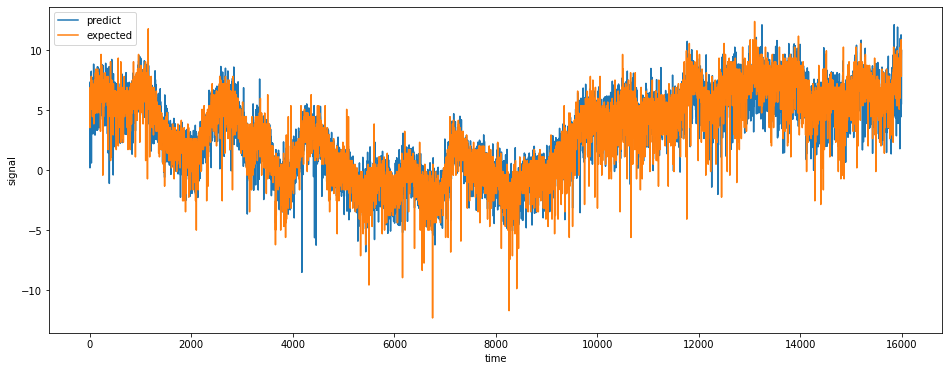

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

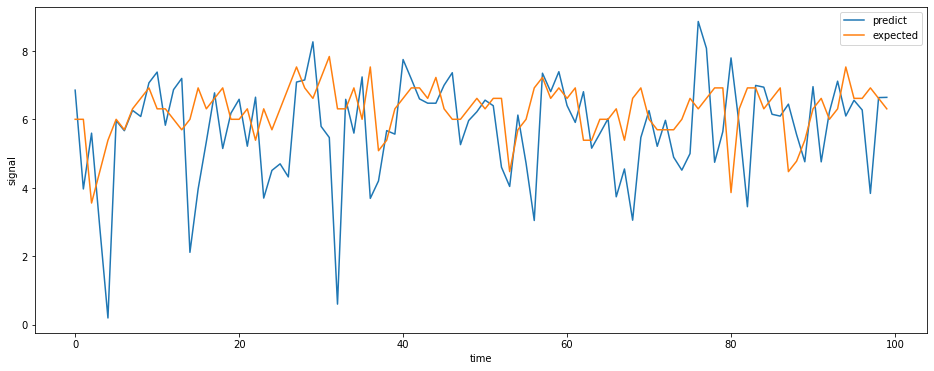

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0026801482


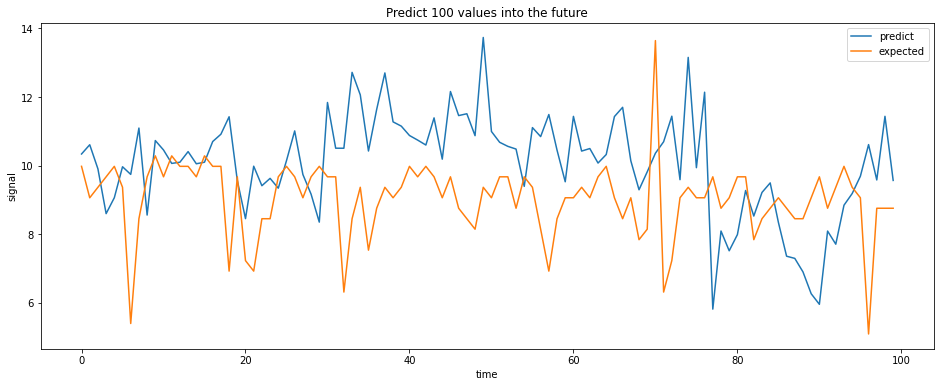

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N256_T100




In [ ]:
!unzip L1N256T100.zip

Archive:  L1N256T100.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 100
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15900, 100, 1)
y train shape:  (15900,)
X test shape:  (3900, 100, 1)
y test shape:  (3900,)


In [ ]:
loaded.evaluate(X_train, y_train)

497/497 [==============================] - 35s 69ms/step - loss: 4.4392e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0141 - cosine_proximity: 1.0000


[0.0004439224721863866, 0.0, 0.014077594503760338, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

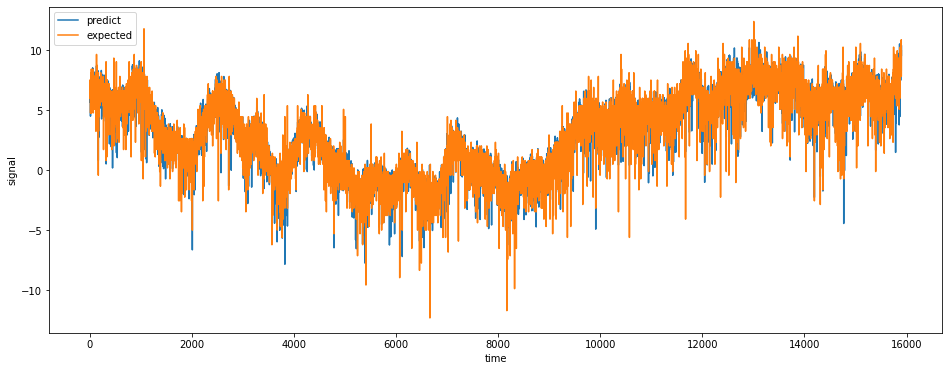

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

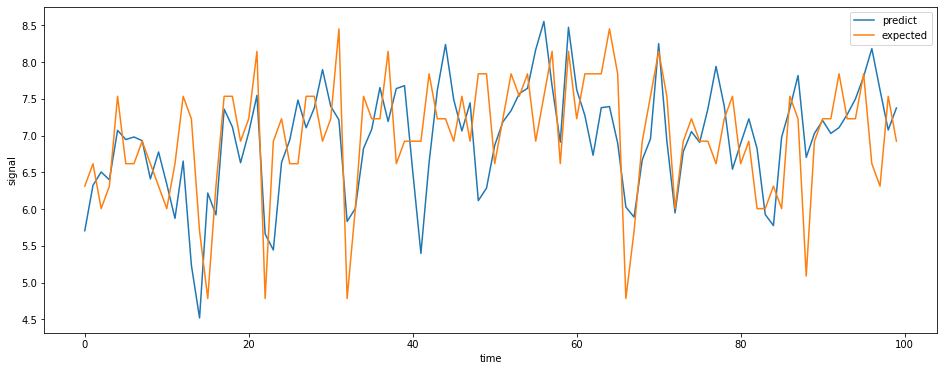

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0009319918


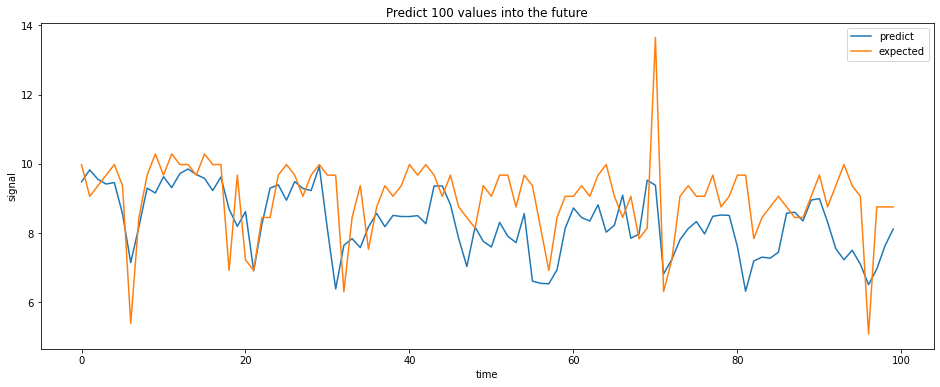

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()

#### L1_N512_T200




In [ ]:
!unzip L1N512T200.zip

Archive:  L1N512T200.zip
replace model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: model/saved_model.pb    
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [ ]:
loaded = keras.models.load_model("model")

For this model we only used 20k data

In [ ]:
norm_data_cropped = norm_data[:20000]
y = norm_data_cropped.ravel()
train_split, test_split, ytrain, ytest = train_test_split(norm_data_cropped, y, test_size = test_size, random_state = 42, shuffle = False)
print('train shape: ', train_split.shape)
print('y train shape: ', train_split.shape)
print('test shape: ', test_split.shape)
print('y test shape: ', ytest.shape)

train shape:  (16000, 1)
y train shape:  (16000, 1)
test shape:  (4000, 1)
y test shape:  (4000,)


Now we build the time series

In [ ]:
time_steps = 200
X_train, y_train = get_data_time_steps(train_split, ytrain, time_steps)
X_test, y_test = get_data_time_steps(test_split, ytest, time_steps)

print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (15800, 200, 1)
y train shape:  (15800,)
X test shape:  (3800, 200, 1)
y test shape:  (3800,)


In [ ]:
loaded.evaluate(X_train, y_train)

494/494 [==============================] - 144s 290ms/step - loss: 5.2557e-04 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0158 - cosine_proximity: 1.0000


[0.0005255721043795347, 0.0, 0.01577930711209774, 1.0]

Now we will check how well the Neural Network Performed

In [ ]:
y_predict = loaded.predict(X_train)

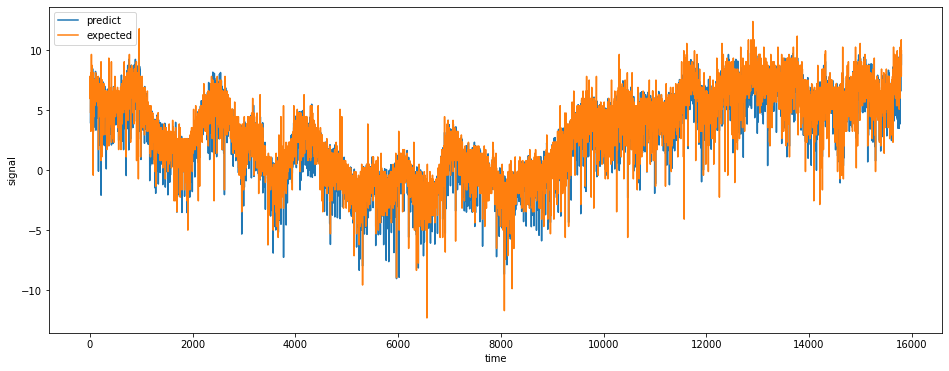

In [ ]:
y_predict = inverse_normalization(y_predict)
y_train_inv = inverse_normalization(y_train.reshape(len(y_train),1))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0]), y_predict, label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0]), y_train_inv, label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

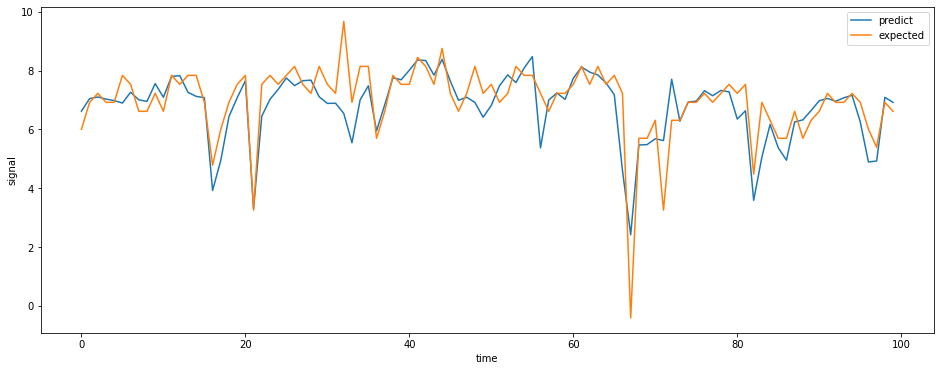

In [ ]:
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_predict[:100], label = 'predict')
expec_plot,  = plt.plot(range(0, X_train.shape[0])[:100], y_train_inv[:100], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.show()

Predicting the future

mse: 0.0009319918


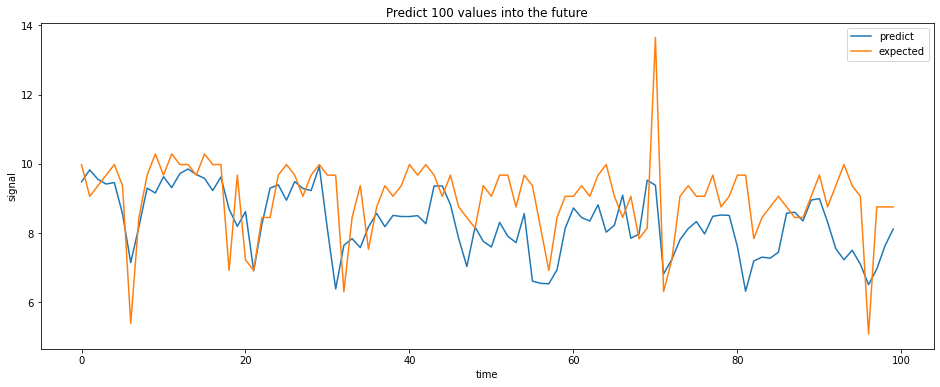

In [ ]:
n_steps_future =  100

# generates the next predict set
def generate_future_predict_time_series(Xtrain):
  X_future = []
  for i in range(Xtrain.shape[0], Xtrain.shape[0] + 1):
    X_future.append(Xtrain[i - time_steps: i, :])
  return np.array(X_future)

# we will have to update the train data atleast for time_series times so we can get the last time series values
X_future_train_data = train_split

# loop n_months times
for i in range(n_steps_future):
  
  # get future predict
  X_future_pred = generate_future_predict_time_series(X_future_train_data)
  # predict model
  y_future_pred = loaded.predict(X_future_pred)
  #print(f'month: {len(ytrain)+i} predicted {inverse_scaling(y_future_pred)}')
  # train with new values
  #model_copy.fit(X_future_pred, y_future_pred, epochs=1, batch_size=1)
  
  # update X_future_train_data,
  X_future_train_data = np.concatenate((X_future_train_data, y_future_pred))

  
print('mse:', mean_squared_error(ytest[:n_steps_future], X_future_train_data[len(train_split):]))
plt.figure(1, figsize =(16, 6))
pred_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(X_future_train_data[len(train_split):])[:,0], label = 'predict')
expec_plot,  = plt.plot(range(0, n_steps_future), inverse_normalization(ytest.reshape(len(ytest), 1)[:n_steps_future])[:, 0], label = 'expected')
plt.legend(handles=[pred_plot, expec_plot])
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Predict 100 values into the future')
plt.show()